## Import

In [2]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Mount 및 압축 풀기

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


현재 디렉터리 위치

In [ ]:
!pwd

/content


In [ ]:
# !ls "/content/gdrive/My Drive"

- [Colab에서 zip file 읽어오기](https://stackoverflow.com/questions/60582471/resuing-a-zip-file-from-google-colab)


읽어온 zip file의 위치 및 명명 객체 이름 설정

In [ ]:
# !cp "/content/gdrive/My Drive/celeba/img_align_celeba.zip" "DCGAN_example"

해당 경로에 DCGAN이라는 파일 이름으로 압축을 품 

  - 압축 풀다가 튕겨서 그냥 풀린 데이터로만 할래...(로컬에서 서버 쓰고 싶다...)

In [ ]:
# !unzip -uq "DCGAN_example" -d "/content/gdrive/My Drive/celeba/DCGAN"

## 데이터 받아오기

In [5]:
dataroot = '/content/gdrive/My Drive/celeba/DCGAN'
workers = 2
batch_size = 128
image_size = 64
nc = 3 # Training Image에서의 Channel의 개수 
nz = 100 # Latent vector의 크기 
ngf = 64 # Generator에서의 feature map의 사이즈
ndf = 64 # Discriminator에서의 feature map의 사이즈
num_epochs = 5 
lr = 0.0002
beta1 = 0.5
ngpu = 1

> Create the dataset  

> Create the dataloader

> Set the device to run

> Visualie some of training data

- [transforms](https://green-late7.tistory.com/56) 에 대한 몇 가지 설명

- [next와 iter](https://python.bakyeono.net/chapter-7-4.html) 에 대한 설명

- [이미지 Normalization](https://goodtogreate.tistory.com/entry/Neural-Network-%EC%A0%81%EC%9A%A9-%EC%A0%84%EC%97%90-Input-data%EB%A5%BC-Normalize-%ED%95%B4%EC%95%BC-%ED%95%98%EB%8A%94-%EC%9D%B4%EC%9C%A0) 에 대한 설명

Pytorch는 기본적으로 이미지를 [Batch Size, Channel, Width, Height]와 같은 형태로 저장 

->  matplotlib으로 출력하기 위해서는  [Width, Height, Channel] 형태로 바꾸어 주어야.

[Reference](https://ndb796.tistory.com/372)

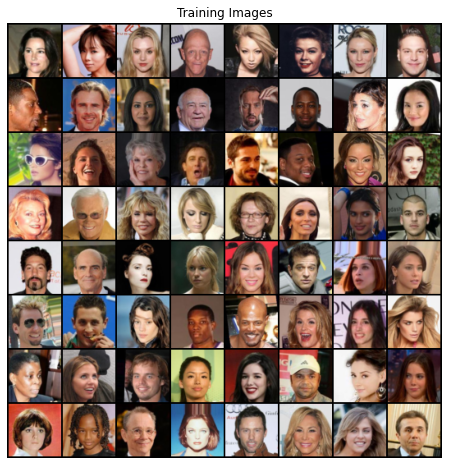

In [7]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                                transforms.Resize(image_size), # 이미지 사이즈를 size로 변경
                                transforms.CenterCrop(image_size),                         
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),                         
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


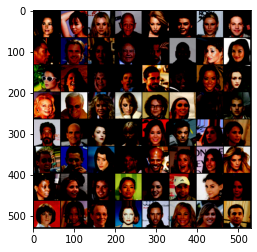

In [ ]:
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2).cpu(), (1,2,0)))

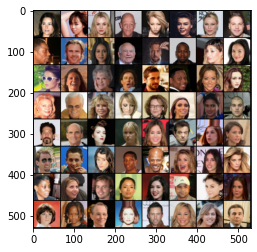

In [ ]:
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, 
#                                          normalize=True).cpu(), (1,2,0)))

## 실행

### Weight Initialization

[클래스 이름 참조하기](https://m.blog.naver.com/wideeyed/221906742759)

In [8]:
# netG와 netD에서 호출될 custom weights initialization 함수
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

### Generator

- Generator G: latent space vector `z` -> data-space

- 현재 다루고 있는 데이터는 이미지 데이터이기 때문에, 결국 latent space vector를받아서,

  training image와 같은 size의 RGB image를 generate 해야 (3x64x64)

  - 방법: 일련의 Strided 2-dim conv transpose layers를 사용 (각각은 2d BN layer와 ReLU 사용)
  끝에는 tanh를 사용해서 [-1,1] input data와 같은 범위의 output을 generate

- conv-transpose layer 이후에 BN이 있는 건 기억할만 함. (DCGAN paper의 아주 중요한 contributio)

  - Training 동안에 gradient의 flow를 돕는다. 



In [9]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # Input: z
        nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(True),
        # state size, (ngf*8)x4x4
        nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),
        # state size, (ngf*4)x8x8
        nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(True),
        # state size, (ngf*2)x16x16
        nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        # state. (ngf)x32x32
        nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        # state size, (nc)x64x64
    )

  def forward(self, input):
    return self.main(input)

Generator 만들기!

In [10]:
netG = Generator(ngpu).to(device)

if (device.type == 'cude') and (ngpu>1):
  netG = nn.DataParallel(netG, list(range(ngpu)))

# Random하게 모든 weight들을 initialize하기 위해 weights_init function 적용!
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Discriminator

- Binary Classification 네트워크 (Input으로 Image를 받아서, 해당 이미지가 real일 scalar 확률값을 출력)

- 3x64x64 이미지를 받아서 -> Conv2d, BN, LeakyReLU 를 거쳐, 마지막에는 Sigmoid에 통과시켜 확률값을 얻음.

- DCGAN 논문에서는 downsample을 위해 Pooling을 사용하는 것보다 Strided convolution을 사용하는 것이 좋다고 얘기하고 있음. (네트워크가 자신의 pooling function도 학습하도록 하기 때문)

  - BN, LeakyReLU: G, D 모두에게 중요한 학습 과정에 있어 gradient flow가 용이하도록 도움

In [11]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      # input: (nc) x 64 x 64
      nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf)x32x32 
      nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf*2),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*2)x16x16
      nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf*4),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*4)x8x8
      nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf*8),
      nn.LeakyReLU(0.2, inplace=True),
      # state size, (ndf*8) * 4 x 4
      nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    return self.main(input)

In [12]:
netD = Discriminator(ngpu).to(device)

if (device=='cude') and (ngpu>1):
  netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Loss function과 Optimizer

- BCELoss를 사용할 것 (Binary Cross Entropy loss)

  - ![BCELoss](https://latex.codecogs.com/gif.latex?l%28x%2Cy%29%20%3D%20L%20%3D%20%5C%7Bl_1%2C%20...%2C%20l_N%5C%7D%5ET%2C%20ln%20%3D%20-%5By_n%20%5Ccdot%20log%28x_n%29%20&plus;%20%281-y_n%29%20%5Ccdot%20log%281-x_n%29%5D)

  - BCELoss를 사용하면, Objective function의 두 log 부분을 계산 해줌! (log(D(x)) & log(1-D(G(z))))
  - BCE equation의 어떤 부분을 y input과 함께 사용할 것인지 명시해줄 수 있음. 

- Real label: 1, Fake label: 0 (Convention in GAN)

In [13]:
criterion = nn.BCELoss()

# Generator의 진행상황을 Visualize 하는 데에 사용할 Latent vector들의 batch를 만들어준다.
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
# for_example = torch.randn(3, 10, 1, 1, device=device)
# print(for_example)
# print(for_example.shape)

tensor([[[[ 1.1256]],

         [[ 0.4109]],

         [[-0.7805]],

         [[-1.9268]],

         [[ 0.5821]],

         [[ 2.6866]],

         [[ 0.9332]],

         [[-0.1469]],

         [[-0.2459]],

         [[ 0.1566]]],


        [[[-0.6244]],

         [[ 1.1443]],

         [[ 0.7649]],

         [[-0.1414]],

         [[ 0.1806]],

         [[-1.8002]],

         [[-0.1318]],

         [[-0.2125]],

         [[ 0.1659]],

         [[ 1.4163]]],


        [[[-0.3898]],

         [[ 1.4432]],

         [[ 0.3428]],

         [[ 0.2341]],

         [[ 0.5950]],

         [[ 0.0463]],

         [[ 0.4929]],

         [[ 1.5137]],

         [[-1.4463]],

         [[-0.0557]]]])
torch.Size([3, 10, 1, 1])


### Training

- 명심할 것

  - 잘못된 hyperparameter 셋팅은 무엇이 잘못되었는지에 대한 설명이라곤 거의 없이 mode collapse를 만들어 냄.

  - Training
    - Part1. Discriminator 업데이트
    - Part2. Generator 업데이트

- Part1. Discriminator 훈련
  - "Update the discriminator by ascending its stochastic gradient!"
  - log(D(x)) + log(1-D(G(z)) 를 Maximize 하고 싶어함.
    - 2단계를 거쳐 계산할 것
      - Step1. 
        
        : Training set으로부터 Real Sample의 Batch를 만든다. -> D를 Forward pass -> log(D(x) loss 계산 -> Backward Pass를 통해 gradient 계산

      - Step2.

        : 현재의 Generator에서 fake sample batch를 만든다 -> D를 Forward pass -> log(1-D(G(z)) loss를 계산 -> Backward pass를 통해 gradient를 `accumulate`

- Part2. Generator 훈련
  - 더 좋은 fake를 만드려는 목적에서 log(1-D(G(z))를 Minimize하고 싶어함
  - 이에 대한 변형으로 log(D(G(z))를 Maximize!
    
    ```
    - Part1의 D로부터 Generator output을 분류
    - Real label을 이용하여 G의 loss를 계산
    - G의 gradient를 backward pass를 통해 계산
    - optimiazer step으로 G의 파라미터 업데이트
    ```

- 매 Epoch마다 기록할 statistic reporting
  - Loss_D: log(D(x))+log(D(G(z)))
  - Loss_G: log(D(G(z)))
  - D(x): 모든 real batch에 대한 D의 avg output
    - 이 값은 1에 가까워져서, G의 성능이 향상될 때에, 이론적으로는 0.5에 가까워져야 
  - D(G(z)): 모든 fake batch에 대한 D의 avg output
    - 이 값은 처음에는 0근처에서 시작해서, G의 성능이 향상될 수록 0.5에 가까워져야.

In [14]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print('Training Loop 시작...')

for epoch in range(num_epochs):
  for i, data in enumerate(dataloader, 0):

    #######################################################
    ## D를 업데이트 ( Maximize log(D(x)) + log(1-D(G(z))) )
    #######################################################

    ## 모든 'Real' batch로 train ##
    netD.zero_grad()
    # Format batch
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
    # Forward pass
    output = netD(real_cpu).view(-1)
    # Loss 계산
    errD_real = criterion(output, label)
    # D의 gradient 계산 
    errD_real.backward()
    D_x = output.mean().item()

    ## 모든 'Fake' batch로 train ##
    # Latent vectors의 batch를 generate
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # G로 fake image batch generate
    fake = netG(noise)
    label.fill_(fake_label)
    # D를 갖고 모든 fake batch를 classify
    output = netD(fake.detach()).view(-1)
    # D의 loss 계산
    errD_fake = criterion(output, label)
    # 이 batch에 대한 gradient 계산
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # 모든 real, fake batch들의 gradient를 더한다.
    errD = errD_real + errD_fake
    # D를 update
    optimizerD.step()

  
    ############################################
    ## G를 업데이트 ( Maximize log(D(G(z))) ) ##
    ############################################

    netG.zero_grad()
    label.fill_(real_label) # Fake label은 Generator cost에서는 real

    output = netD(fake).view(-1)
    errG = criterion(output, label)
    errG.backward()
    D_G_z2 = output.mean().item()
    optimizerG.step()

    # 중간중간에 stats 찍기
    if i % 50 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
      
    # 차후 Plotting을 위해 loss들 저장
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # fixed_noise를 통해 generator가 어떻게 작동하고 있는지 확인. 
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    iters+=1

Training Loop 시작...
[0/5][0/106]	Loss_D: 1.6615	Loss_G: 5.4230	D(x): 0.5512	D(G(z)): 0.5501 / 0.0073
[0/5][50/106]	Loss_D: 0.1818	Loss_G: 27.4265	D(x): 0.9449	D(G(z)): 0.0000 / 0.0000
[0/5][100/106]	Loss_D: 0.5763	Loss_G: 8.1680	D(x): 0.8763	D(G(z)): 0.2489 / 0.0018
[1/5][0/106]	Loss_D: 1.4206	Loss_G: 3.2079	D(x): 0.5036	D(G(z)): 0.0028 / 0.0594
[1/5][50/106]	Loss_D: 0.5565	Loss_G: 2.8623	D(x): 0.7367	D(G(z)): 0.1197 / 0.0920
[1/5][100/106]	Loss_D: 2.2090	Loss_G: 5.0952	D(x): 0.2538	D(G(z)): 0.0025 / 0.0144
[2/5][0/106]	Loss_D: 1.0876	Loss_G: 9.4592	D(x): 0.9422	D(G(z)): 0.5325 / 0.0003
[2/5][50/106]	Loss_D: 0.2591	Loss_G: 6.3968	D(x): 0.8454	D(G(z)): 0.0324 / 0.0034
[2/5][100/106]	Loss_D: 0.7349	Loss_G: 5.2754	D(x): 0.8824	D(G(z)): 0.3891 / 0.0141
[3/5][0/106]	Loss_D: 0.5211	Loss_G: 3.8556	D(x): 0.8298	D(G(z)): 0.2192 / 0.0426
[3/5][50/106]	Loss_D: 0.5228	Loss_G: 3.2459	D(x): 0.8108	D(G(z)): 0.1744 / 0.0791
[3/5][100/106]	Loss_D: 0.7326	Loss_G: 6.2244	D(x): 0.9355	D(G(z)): 0.4130 / 0.

### **Results**

- Training 동안의 D와 G의 loss를 트래킹

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54984 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50504 missing from current font.
  font.set_

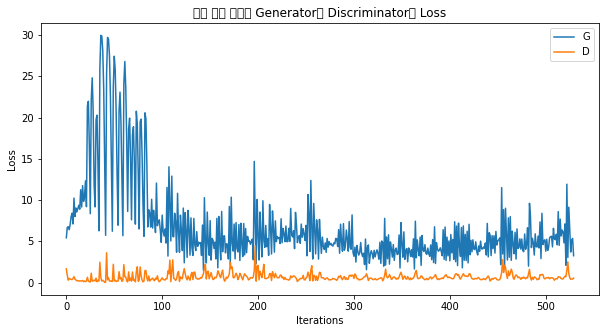

In [15]:
plt.figure(figsize=(10,5))
plt.title('훈련 하는 동안의 Generator와 Discriminator의 Loss')
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

- G의 Progression 시각화

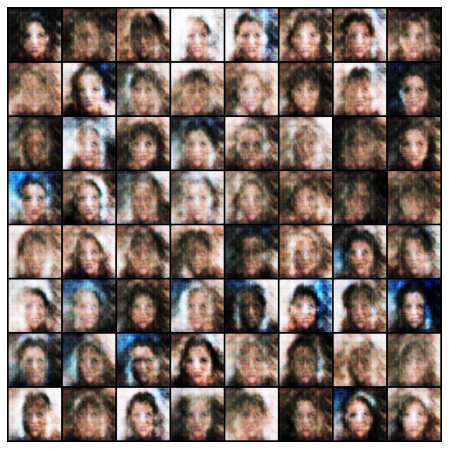

In [18]:
fig = plt.figure(figsize=(8,8))
plt.axis('off')
ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

- Real 이미지와 Fake 이미지 간의 비교